In [20]:
#imports
import pandas as pd
import numpy as np
import math
from matplotlib import pyplot as plt


In [21]:
#data imports
regions = pd.read_csv(r'risk_data.csv', sep=";", usecols=[0])
risk_data = pd.read_csv(r'risk_data.csv', sep=";", index_col=0)
asset_values = pd.read_csv(r'asset_values.csv', sep = ";", index_col=0)
influences = pd.read_csv(r'influences.csv', sep=";", index_col = 0)
base_data = pd.read_csv(r'base_data.csv', sep=";", index_col=0)

In [22]:
### calculating base parameters
agg_risk = risk_data.sum(axis=1)

#risk per capita
rpk = agg_risk/base_data["pop"]
# yearly wage per capity
yearly_wage = base_data["sim_wage"]*52
# total population
total_pop = sum(base_data["pop"])
#gdp per capita = productivity
productivity = base_data["gdp"]/base_data["pop"]

In [40]:
### Function to calculate effect of transfer schedule

def pop_dens_func (population):
    return population/base_data["area"]

def wage_func(population_density):
    return (0.0359 * population_density + 598.74) * 52

def risk_pc(population):
    return agg_risk/population

def v_func(wages, transfers, risk_p_capita):
    return base_data["b_i"] * (wages + transfers) / risk_p_capita

def Pi_func(v):
    return v/sum(v)

def H_func(pi):
    return pi * total_pop

def A_func(H):
    return H * productivity
    '''
    A = []
    for i in range(len(agg_risk)):
        A.append(math.pow(H[i], (base_data["prod"][i]/100)))
        
    return A'''

def welfare_func(A):
    return sum(A)# - sum(base_data["pop"] * productivity)

# For sanity checks in this cell
pop_dens_0 = pop_dens_func(base_data["pop"])
wage_0 = wage_func(pop_dens_0)
risk_0 = risk_pc(base_data["pop"])
v0 = v_func(wage_0,0,risk_0)
pi_0 = Pi_func(v0)
h_0 = H_func (pi_0)
a_0 = A_func(h_0)
welf_0 = welfare_func(a_0)


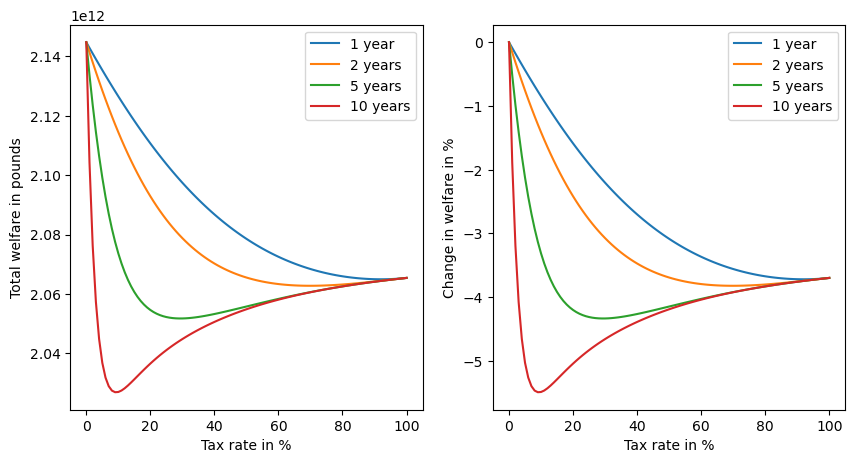

In [57]:
### transfer function 1: collect taxes based on income and distribute according to risk


def transfer_calculator(step, taxes):
    pop_dens_list = [None] * (step+1)
    wage_list = [None] * (step+1)
    risk_list = [None] * (step+1)
    v_list = [None] * (step+1)
    pi_list = [None] * (step+1)
    h_list = [None] * (step+1)
    a_list = [None] * (step+1)
    welf_list =[None] * (step+1)

    # initialization for the first step
    pop_dens_list[0] = pop_dens_0
    wage_list[0] = wage_0
    risk_list[0] = risk_0
    transfer = taxes * sum(wage_list[0])*risk_list[0]/sum(risk_list[0]) - taxes * wage_list[0]
    v_list[0] = v_func(wage_0, transfer, risk_0)
    pi_list[0] = Pi_func(v_list[0])
    h_list[0] = H_func (pi_list[0])
    a_list[0] = A_func(h_list[0])
    welf_list[0] = welfare_func(a_list[0])

    for i in range(1,step+1):
        pop_dens_list[i] = pop_dens_func(h_list[i-1])
        wage_list[i] = wage_func(pop_dens_list[i])
        risk_list[i] = risk_pc(h_list[i-1])
        transfer = taxes * sum(wage_list[i])*risk_list[i]/sum(risk_list[i]) - taxes * wage_list[i]
        v_list[i] = v_func(wage_list[i], transfer, risk_list[i])
        pi_list[i] = Pi_func(v_list[i])
        h_list[i] = H_func (pi_list[i])
        a_list[i] = A_func(h_list[i])
        welf_list[i] = welfare_func(a_list[i])

    return welf_list


percentage = []
welfare1 = []
welfare2 = []
welfare5 = []
welfare10 = []
relwelfare1 = []
relwelfare2 = []
relwelfare5 = []
relwelfare10 = []

for i in range(101):
    percentage.append(i)
    welfare1.append(transfer_calculator(1,i/100)[1])
    welfare2.append(transfer_calculator(2,i/100)[2])
    welfare5.append(transfer_calculator(5,i/100)[5])
    welfare10.append(transfer_calculator(10,i/100)[10])

for i in range(101):
    relwelfare1.append((welfare1[i]-welfare1[0])*100/welfare1[0])
    relwelfare2.append((welfare2[i]-welfare2[0])*100/welfare2[0])
    relwelfare5.append((welfare5[i]-welfare5[0])*100/welfare5[0])
    relwelfare10.append((welfare10[i]-welfare10[0])*100/welfare10[0])


f, (ax1,ax2) = plt.subplots(1,2,sharex=True, figsize=(10,5))
ax1.plot(percentage, welfare1, label = "1 year")
ax1.plot(percentage, welfare2, label = "2 years")
ax1.plot(percentage, welfare5, label = "5 years")
ax1.plot(percentage, welfare10, label = "10 years")
ax1.legend(loc="upper right")
ax1.set_xlabel("Tax rate in %")
ax1.set_ylabel("Total welfare in pounds")
ax2.plot(percentage, relwelfare1, label = "1 year")
ax2.plot(percentage, relwelfare2, label = "2 years")
ax2.plot(percentage, relwelfare5, label = "5 years")
ax2.plot(percentage, relwelfare10, label = "10 years")
ax2.legend(loc="upper right")
ax2.set_xlabel("Tax rate in %")
ax2.set_ylabel("Change in welfare in %")
#plt.ylim([0,2.5e12])
plt.show()

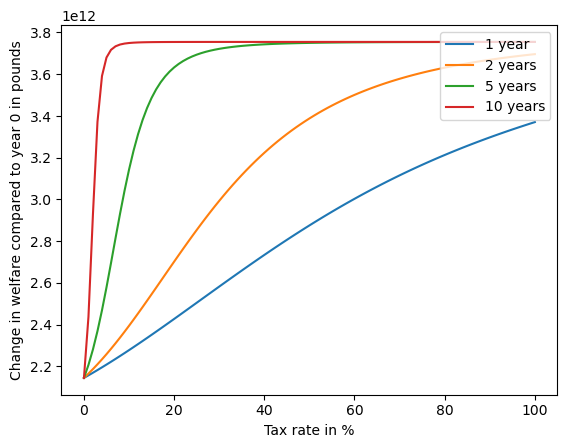

In [41]:
### transfer paymenet method 2: collecting a tax but transferring according to risk and population density

#normalizing risk and population density
def normalizer(population):
    rpk = agg_risk/population
    rpk_norm = rpk/sum(rpk)
    pop_density = population/base_data["area"]
    pop_density_norm = pop_density/sum(pop_density)
    
    return (rpk_norm+pop_density_norm)/2

#transfer function

def transfer_calculator(step, taxes):
    pop_dens_list = [None] * (step+1)
    wage_list = [None] * (step+1)
    risk_list = [None] * (step+1)
    v_list = [None] * (step+1)
    pi_list = [None] * (step+1)
    h_list = [None] * (step+1)
    a_list = [None] * (step+1)
    welf_list =[None] * (step+1)

    # initialization for the first step
    pop_dens_list[0] = pop_dens_0
    wage_list[0] = wage_0
    risk_list[0] = risk_0
    transfer = taxes * sum(wage_list[0]) * normalizer(base_data["pop"])- taxes * wage_list[0]
    v_list[0] = v_func(wage_0, transfer, risk_0)
    pi_list[0] = Pi_func(v_list[0])
    h_list[0] = H_func (pi_list[0])
    a_list[0] = A_func(h_list[0])
    welf_list[0] = welfare_func(a_list[0])

    for i in range(1,step+1):
        pop_dens_list[i] = pop_dens_func(h_list[i-1])
        wage_list[i] = wage_func(pop_dens_list[i])
        risk_list[i] = risk_pc(h_list[i-1])
        transfer = taxes * sum(wage_list[i]) * normalizer(h_list[i-1])- taxes * wage_list[i]
        v_list[i] = v_func(wage_list[i], transfer, risk_list[i])
        pi_list[i] = Pi_func(v_list[i])
        h_list[i] = H_func (pi_list[i])
        a_list[i] = A_func(h_list[i])
        welf_list[i] = welfare_func(a_list[i])

    return welf_list


percentage = []
welfare1t2 = []
welfare2t2 = []
welfare5t2 = []
welfare10t2 = []

for i in range(101):
    percentage.append(i)
    welfare1t2.append(transfer_calculator(1,i/100)[1])
    welfare2t2.append(transfer_calculator(2,i/100)[2])
    welfare5t2.append(transfer_calculator(5,i/100)[5])
    welfare10t2.append(transfer_calculator(10,i/100)[10])

plt.plot(percentage, welfare1t2, label = "1 year")
plt.plot(percentage, welfare2t2, label = "2 years")
plt.plot(percentage, welfare5t2, label = "5 years")
plt.plot(percentage, welfare10t2, label = "10 years")
plt.legend(loc="upper right")
plt.xlabel("Tax rate in %")
plt.ylabel("Change in welfare compared to year 0 in pounds")
plt.show()

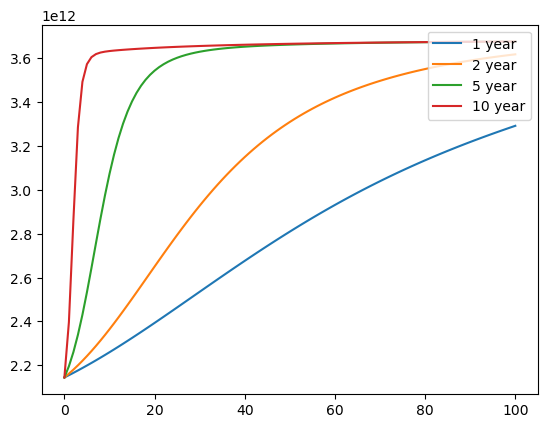

In [54]:
percentage
totwel1 = [welfare1[i] + welfare1t2[i] for i in range(len(welfare1))]
totwel2 = [welfare2[i] + welfare2t2[i] for i in range(len(welfare2))]
totwel5 = [welfare5[i] + welfare5t2[i] for i in range(len(welfare5))]
totwel10 = [welfare10[i] + welfare10t2[i] for i in range(len(welfare10))]

plt.plot(percentage, totwel1, label = "1 year")
plt.plot(percentage, totwel2, label = "2 year")
plt.plot(percentage, totwel5, label = "5 year")
plt.plot(percentage, totwel10, label = "10 year")
plt.legend(loc="upper right")
#plt.ylim([0,2.5e12])
plt.show()

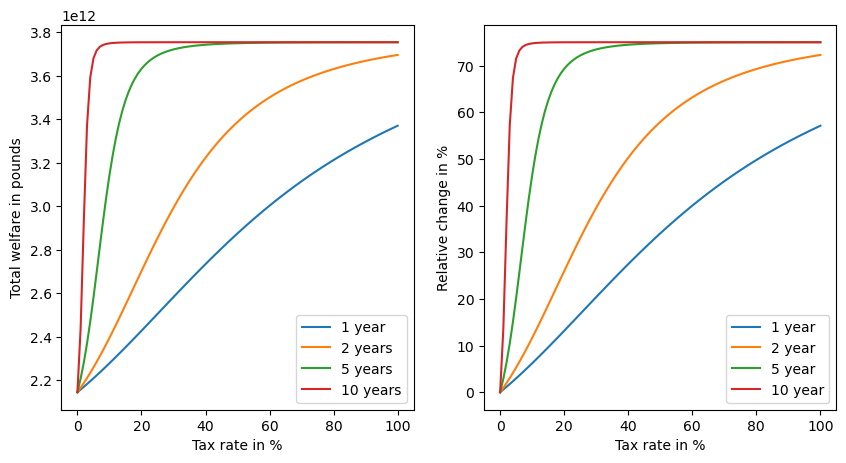

In [53]:
percentage = []
welfare1t2 = []
welfare2t2 = []
welfare5t2 = []
welfare10t2 = []
relwelfare1t2 = []
relwelfare2t2 = []
relwelfare5t2 = []
relwelfare10t2 =[]

for i in range(101):
    percentage.append(i)
    welfare1t2.append(transfer_calculator(1,i/100)[1])
    welfare2t2.append(transfer_calculator(2,i/100)[2])
    welfare5t2.append(transfer_calculator(5,i/100)[5])
    welfare10t2.append(transfer_calculator(10,i/100)[10])

for i in range(101):
    relwelfare1t2.append((welfare1t2[i]-welfare1t2[0])*100/welfare1t2[0])
    relwelfare2t2.append((welfare2t2[i]-welfare2t2[0])*100/welfare2t2[0])
    relwelfare5t2.append((welfare5t2[i]-welfare5t2[0])*100/welfare5t2[0])
    relwelfare10t2.append((welfare10t2[i]-welfare10t2[0])*100/welfare10t2[0])

f, (ax1,ax2) = plt.subplots(1,2,sharex=True, figsize =(10 , 5))
ax1.plot(percentage, welfare1t2, label = "1 year")
ax1.plot(percentage, welfare2t2, label = "2 years")
ax1.plot(percentage, welfare5t2, label = "5 years")
ax1.plot(percentage, welfare10t2, label = "10 years")
ax1.legend(loc="lower right")
ax1.set_xlabel("Tax rate in %")
ax1.set_ylabel("Total welfare in pounds")

ax2.plot(percentage, relwelfare1t2, label="1 year")
ax2.plot(percentage, relwelfare2t2, label="2 year")
ax2.plot(percentage, relwelfare5t2, label="5 year")
ax2.plot(percentage, relwelfare10t2, label="10 year")
ax2.legend(loc="lower right")
ax2.set_ylabel("Relative change in %")
ax2.set_xlabel("Tax rate in %")
plt.show()

Region
North East England           79.428361
North West England           70.964155
Yorkshire and the Humber     21.079873
East Midlands                99.888009
West Midlands               100.000000
East of England              74.904488
London                       85.481781
South East England            0.000000
South West England           89.015958
Wales                        31.622133
Scotland                     52.237747
Northern Ireland             32.436868
dtype: float64


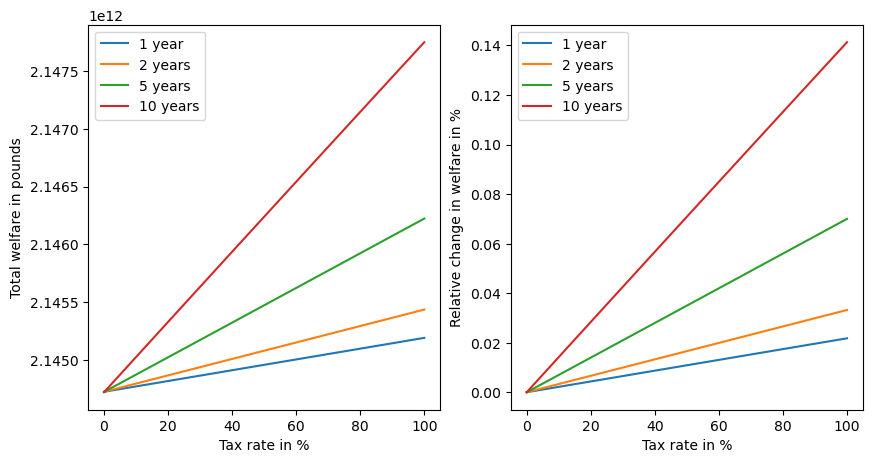

In [68]:
### transfer schedule 3

### transfer function 1: collect taxes based on income and distribute according to risk

tax_list_0 = 1 - risk_0/sum(risk_0)
min_tax = min(tax_list_0)
max_tax = max(tax_list_0)
tax_list_0= 100*(tax_list_0-min_tax)/(max_tax-min_tax)

print(tax_list_0)

def transfer_calculator(step, taxes):
    pop_dens_list = [None] * (step+1)
    wage_list = [None] * (step+1)
    risk_list = [None] * (step+1)
    v_list = [None] * (step+1)
    pi_list = [None] * (step+1)
    h_list = [None] * (step+1)
    a_list = [None] * (step+1)
    welf_list =[None] * (step+1)

    # initialization for the first step
    pop_dens_list[0] = pop_dens_0
    wage_list[0] = wage_0
    risk_list[0] = risk_0
    transfer = sum(taxes * tax_list_0)* h_0/sum(h_0) - taxes * tax_list_0
    v_list[0] = v_func(wage_0, transfer, risk_0)
    pi_list[0] = Pi_func(v_list[0])
    h_list[0] = H_func (pi_list[0])
    a_list[0] = A_func(h_list[0])
    welf_list[0] = welfare_func(a_list[0])

    for i in range(1,step+1):
        pop_dens_list[i] = pop_dens_func(h_list[i-1])
        wage_list[i] = wage_func(pop_dens_list[i])
        risk_list[i] = risk_pc(h_list[i-1])
        transfer = sum(taxes * tax_list_0) * h_list[i-1]/sum(h_list[i-1]) - taxes * tax_list_0
        v_list[i] = v_func(wage_list[i], transfer, risk_list[i])
        pi_list[i] = Pi_func(v_list[i])
        h_list[i] = H_func (pi_list[i])
        a_list[i] = A_func(h_list[i])
        welf_list[i] = welfare_func(a_list[i])

    return welf_list


percentage = []
welfare1t3 = []
welfare2t3 = []
welfare5t3 = []
welfare10t3 = []
relwelfare1t3 = []
relwelfare2t3 = []
relwelfare5t3 = []
relwelfare10t3 = []

for i in range(101):
    percentage.append(i)
    welfare1t3.append(transfer_calculator(1,i/100)[1])
    welfare2t3.append(transfer_calculator(2,i/100)[2])
    welfare5t3.append(transfer_calculator(5,i/100)[5])
    welfare10t3.append(transfer_calculator(10,i/100)[10])

for i in range(101):
    relwelfare1t3.append((welfare1t3[i]-welfare1t3[0])*100/welfare1t3[0])
    relwelfare2t3.append((welfare2t3[i]-welfare2t3[0])*100/welfare2t3[0])
    relwelfare5t3.append((welfare5t3[i]-welfare5t3[0])*100/welfare5t3[0])
    relwelfare10t3.append((welfare10t3[i]-welfare10t3[0])*100/welfare10t3[0])

f, (ax1,ax2) = plt.subplots(1,2,sharex=True, figsize = (10,5))
ax1.plot(percentage, welfare1t3, label = "1 year")
ax1.plot(percentage, welfare2t3, label = "2 years")
ax1.plot(percentage, welfare5t3, label = "5 years")
ax1.plot(percentage, welfare10t3, label = "10 years")
ax1.legend(loc="upper left")
ax1.set_xlabel("Tax rate in %")
ax1.set_ylabel("Total welfare in pounds")
ax2.plot(percentage, relwelfare1t3, label = "1 year")
ax2.plot(percentage, relwelfare2t3, label = "2 years")
ax2.plot(percentage, relwelfare5t3, label = "5 years")
ax2.plot(percentage, relwelfare10t3, label = "10 years")
ax2.legend(loc="upper left")
ax2.set_xlabel("Tax rate in %")
ax2.set_ylabel("Relative change in welfare in %")
#plt.ylim([0,2.5e12])
plt.show()

In [9]:
####NEU
# 
# 
# ## Function to calculate effect of transfer schedule

def pop_dens_func (population):
    return population/base_data["area"]

def wage_func(population_density):
    return (0.0359 * population_density + 598.74) * 52

def risk_pc(population):
    return agg_risk/population

def v_func(wages, transfers, risk_p_capita, population_density):
    return base_data["b_i"] * (wages + transfers - (0.0014 * population_density + 7.0373) * wages) / 30 / risk_p_capita
    # Here, i devided the housing prices by 20 as it is a usual time to recoup investment in rentals or loan time for homeowners

def Pi_func(v):
    return v/sum(v)

def H_func(pi):
    return pi * total_pop

def A_func(H):
    return H * productivity
    '''
    A = []
    for i in range(len(agg_risk)):
        A.append(math.pow(H[i], (base_data["prod"][i]/100)))
        
    return A'''

def welfare_func(A):
    return sum(A) - sum(base_data["pop"] * productivity)

# For sanity checks in this cell
pop_dens_0 = pop_dens_func(base_data["pop"])
wage_0 = wage_func(pop_dens_0)
risk_0 = risk_pc(base_data["pop"])
v0 = v_func(wage_0,0,risk_0,pop_dens_0)
pi_0 = Pi_func(v0)
h_0 = H_func (pi_0)
a_0 = A_func(h_0)
welf_0 = welfare_func(a_0)


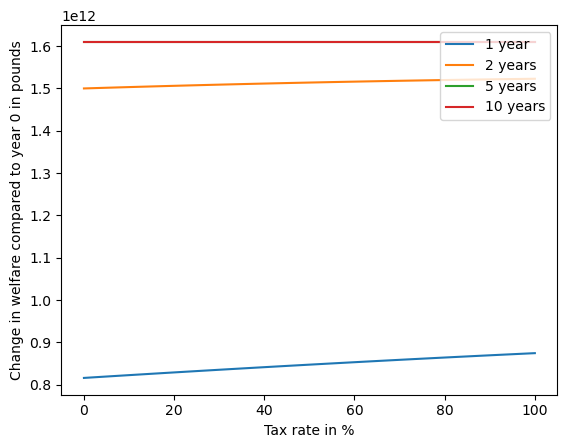

In [10]:
### NEW first schedule

### transfer function 1: collect taxes based on income and distribute according to risk


def transfer_calculator(step, taxes):
    pop_dens_list = [None] * (step+1)
    wage_list = [None] * (step+1)
    risk_list = [None] * (step+1)
    v_list = [None] * (step+1)
    pi_list = [None] * (step+1)
    h_list = [None] * (step+1)
    a_list = [None] * (step+1)
    welf_list =[None] * (step+1)

    # initialization for the first step
    pop_dens_list[0] = pop_dens_0
    wage_list[0] = wage_0
    risk_list[0] = risk_0
    transfer = taxes * sum(wage_list[0])*risk_list[0]/sum(risk_list[0]) - taxes * wage_list[0]
    v_list[0] = v_func(wage_0, transfer, risk_0, pop_dens_0)
    pi_list[0] = Pi_func(v_list[0])
    h_list[0] = H_func (pi_list[0])
    a_list[0] = A_func(h_list[0])
    welf_list[0] = welfare_func(a_list[0])

    for i in range(1,step+1):
        pop_dens_list[i] = pop_dens_func(h_list[i-1])
        wage_list[i] = wage_func(pop_dens_list[i])
        risk_list[i] = risk_pc(h_list[i-1])
        transfer = taxes * sum(wage_list[i])*risk_list[i]/sum(risk_list[i]) - taxes * wage_list[i]
        v_list[i] = v_func(wage_list[i], transfer, risk_list[i],pop_dens_list[i])
        pi_list[i] = Pi_func(v_list[i])
        h_list[i] = H_func (pi_list[i])
        a_list[i] = A_func(h_list[i])
        welf_list[i] = welfare_func(a_list[i])

    return welf_list


percentage = []
welfare1 = []
welfare2 = []
welfare5 = []
welfare10 = []

for i in range(101):
    percentage.append(i)
    welfare1.append(transfer_calculator(1,i/100)[1])
    welfare2.append(transfer_calculator(2,i/100)[2])
    welfare5.append(transfer_calculator(5,i/100)[5])
    welfare10.append(transfer_calculator(10,i/100)[10])

plt.plot(percentage, welfare1, label = "1 year")
plt.plot(percentage, welfare2, label = "2 years")
plt.plot(percentage, welfare5, label = "5 years")
plt.plot(percentage, welfare10, label = "10 years")
plt.xlabel("Tax rate in %")
plt.ylabel("Change in welfare compared to year 0 in pounds")
plt.legend(loc="upper right")
#plt.ylim([0,2.5e12])
plt.show()

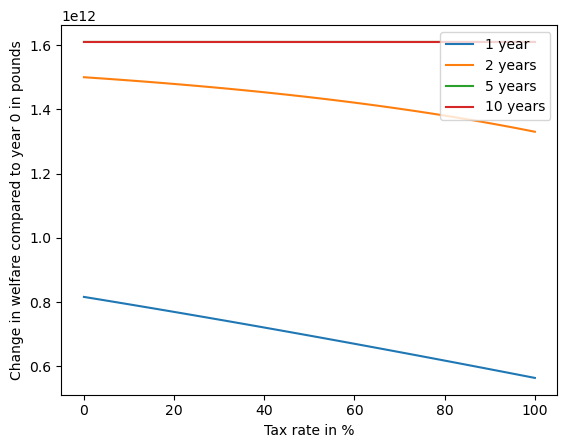

In [11]:
### NEU second schedule

### transfer paymenet method 2: collecting a tax but transferring according to risk and population density

#normalizing risk and population density
def normalizer(population):
    rpk = agg_risk/population
    rpk_norm = rpk/sum(rpk)
    pop_density = population/base_data["area"]
    pop_density_norm = pop_density/sum(pop_density)
    
    return (rpk_norm+pop_density_norm)/2

#transfer function

def transfer_calculator(step, taxes):
    pop_dens_list = [None] * (step+1)
    wage_list = [None] * (step+1)
    risk_list = [None] * (step+1)
    v_list = [None] * (step+1)
    pi_list = [None] * (step+1)
    h_list = [None] * (step+1)
    a_list = [None] * (step+1)
    welf_list =[None] * (step+1)

    # initialization for the first step
    pop_dens_list[0] = pop_dens_0
    wage_list[0] = wage_0
    risk_list[0] = risk_0
    transfer = taxes * sum(wage_list[0]) * normalizer(base_data["pop"]) - taxes * wage_list[0]
    v_list[0] = v_func(wage_0, transfer, risk_0, pop_dens_0)
    pi_list[0] = Pi_func(v_list[0])
    h_list[0] = H_func (pi_list[0])
    a_list[0] = A_func(h_list[0])
    welf_list[0] = welfare_func(a_list[0])

    for i in range(1,step+1):
        pop_dens_list[i] = pop_dens_func(h_list[i-1])
        wage_list[i] = wage_func(pop_dens_list[i])
        risk_list[i] = risk_pc(h_list[i-1])
        transfer = taxes * sum(wage_list[i]) * normalizer(h_list[i-1]) - taxes * wage_list[i]
        v_list[i] = v_func(wage_list[i], transfer, risk_list[i],pop_dens_list[i])
        pi_list[i] = Pi_func(v_list[i])
        h_list[i] = H_func (pi_list[i])
        a_list[i] = A_func(h_list[i])
        welf_list[i] = welfare_func(a_list[i])

    return welf_list


percentage = []
welfare1t2 = []
welfare2t2 = []
welfare5t2 = []
welfare10t2 = []

for i in range(101):
    percentage.append(i)
    welfare1t2.append(transfer_calculator(1,i/100)[1])
    welfare2t2.append(transfer_calculator(2,i/100)[2])
    welfare5t2.append(transfer_calculator(5,i/100)[5])
    welfare10t2.append(transfer_calculator(10,i/100)[10])

plt.plot(percentage, welfare1t2, label = "1 year")
plt.plot(percentage, welfare2t2, label = "2 years")
plt.plot(percentage, welfare5t2, label = "5 years")
plt.plot(percentage, welfare10t2, label = "10 years")
plt.legend(loc="upper right")
plt.xlabel("Tax rate in %")
plt.ylabel("Change in welfare compared to year 0 in pounds")
plt.show()

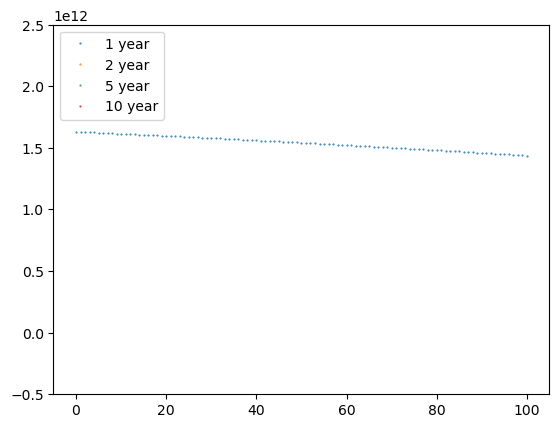

In [12]:
### NEW TOTAL

percentage
totwel1 = [welfare1[i] + welfare1t2[i] for i in range(len(welfare1))]
totwel2 = [welfare2[i] + welfare2t2[i] for i in range(len(welfare2))]
totwel5 = [welfare5[i] + welfare5t2[i] for i in range(len(welfare5))]
totwel10 = [welfare10[i] + welfare10t2[i] for i in range(len(welfare10))]

plt.plot(percentage, totwel1,'o', label = "1 year", markersize = 0.5)
plt.plot(percentage, totwel2, 'o', label = "2 year", markersize = 0.5)
plt.plot(percentage, totwel5, 'o', label = "5 year", markersize = 0.5)
plt.plot(percentage, totwel10, 'o', label = "10 year", markersize = 0.5)
plt.legend(loc="upper left")
plt.ylim([-0.5e12,2.5e12])
plt.show()